##### Copyright 2018 Krzystzof Rusek and Lucjan janowski.
AGH University of Science and Technology

Licensed under the MIT License (the "License");

In [6]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2018 Krzystzof Rusek and Lucjan Janowski

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Subject model in TensorFlow
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/krzysztofrusek/tfp_subject_model/blob/master/notebook/Subject_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/krzysztofrusek/tfp_subject_model/blob/master/notebook/Subject_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [2]:
import numpy as np
import numpy.random as rn
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

# The Model

We begin with a  simple user model inspired by Lucjan's simulation [Confidence Interval Simulation](https://colab.research.google.com/drive/1h-8hCWy_VWBjBQ2V5Nk5BUWN7g-0ApOp#scrollTo=6qBhGj1PBTq4):

$$U_{ij}=\psi_{j} + \Delta_i + \upsilon_i X + \phi_{j} Y$$

$$X,Y \sim N(0,1)%0$$

Where $\psi_j \sim U(1-5)$, i.e. it is from uniform distribution. $\Delta_i \sim N(0,b)$, i.e. it is from the normal distribution with mean 0 and $b$ is such that the total variance of a single PVS is constant. $\upsilon,\phi \sim Gamm $ so variance is related to both the PVS and the subject. For details about the notation visit [Notation](https://docs.google.com/document/d/1o7nD2ztvlrhyTAB2eocb92OY2egDBjvrh-pE-zo32tQ/edit)  
What we know is that the total standard deviation related to specific PVS should be around 0.7-0.8 (Kjell at call at May 7, 2018). 0.75 will be the mean but distribution makes it possible to have different errors for different cases.

The model described above assumes a continuous score scale.
In practice the scale is discrete

# The estimator

Below we provide a basic theoretical description of the estimators demonstrated in this notebook.
In all the estimators we use the common notation for parameters

$$\theta = (\psi_{1},\ldots,\psi_{N_{pvs}}, \Delta_1,\ldots,\Delta_{N_{sub}}, \upsilon_1,\ldots,\upsilon_{N_{sub}} ,\phi_1,\ldots, \phi_{N_{pvs}},)$$,

where $N_{pvs}$ is the number of  PVS used in the test and $N_{sub}$ is the number testers

## MLE

The first approach to fit the parameters is the maximum likelihood estimator (MLE).
This estimator defined as:
$$\hat \theta = \arg\max_\theta P(u|\theta) $$

Knowing the distribution of $U$ estimation is reduced to optimization.
Here we can take advantage of [tensorflow_probability](https://github.com/tensorflow/probability) package and construct a more realistic discrete model using `tfp.distributions.QuantizedDistribution`.

## MAP

There is a problem with MLE, namely the lack of a unique solution. (how to partition variance among testers and PVSs?)
This problem can be avoided by taking the Bayesian approach to estimation.

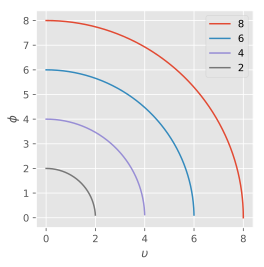

In [4]:
ui=np.linspace(0,8.0,2000)
fii = np.sqrt(8.0**2 - ui**2)
ax=plt.subplot()
ax.plot(ui,fii)
fii = np.sqrt(6.0**2 - ui[ui<6]**2)
ax.plot(ui[ui<6],fii)
fii = np.sqrt(4.0**2 - ui[ui<4]**2)
ax.plot(ui[ui<4],fii)
fii = np.sqrt(2.0**2 - ui[ui<2]**2)
ax.plot(ui[ui<2],fii)
ax.legend([8,6,4,2])
ax.set_aspect(1.0)
ax.set_xlabel(r'$\upsilon$');
ax.set_ylabel(r'$\phi$');

In Bayesian statistic every parameter once being just a number is represented as distribution, so-called prior distribution.
This distribution expresses our knowledge or believes about true values about unknown parameters.

The distribution of unknown parameters is given by the Bayes theorem (hence the name), $u$ stand for the observed data.

$$P(\theta|u)=\frac{P(u ,\theta )}{P(u)}=\frac{P(u |\theta ) P(\theta)}{P(u)}$$

Maximum a posteriori estimator(MAP) obtains estimates of the parameters by

$$ \hat \theta = argmax_\theta   P(\theta|u)$$.

Going to log probs we have 
$$
\log P(\theta|u) = \log P(u |\theta ) + \log P(\theta) - \log P(u)
$$

This is just loglikelihood $ll=\log P(u |\theta )$ plus regularization given by log prior $\log P(\theta)$.
The last term ($P(u)$) can be omitted since it is marginalized by the total probability theorem and does not depend on $\theta$.

$$P(u) = \int P(u |\theta )P(\theta) d\theta $$

If we assume priors:

1. $\Delta_i \sim N(0,b)$ 
1. $\psi_j \sim U(1-5)$ 
1. $\upsilon_i \sim Gamm(\alpha_1,\beta_1)$
1. $\phi_j \sim Gamm(\alpha_2,\beta_2)$

the posterior distribution is given by ([Gamma log-likelihood](https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation))

$$
\log P(\theta|u) = ll + N_{sub}(\alpha_1-1)\overline{\log(\upsilon_i)} -N_{sub} \frac{\bar \upsilon_i}{\beta_1} + N_{pvs} (\alpha_2-1)\overline{\log(\phi_j)} -N_{pvs} \frac{\bar \phi_j}{\beta_2} + \ldots
$$

We know that maximum of $ll$ is not unique under transformations..., however, log prior does not have such symmetry.
In other words, the internal degree of freedom in log likelihood is fixed by prior assumptions about parameters that serve as constraints.

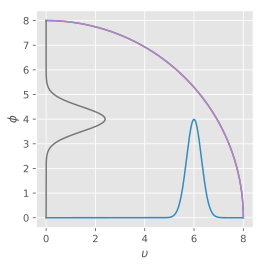

In [8]:
from scipy.stats import norm
ui=np.linspace(0,8.0,2000)
fii = np.sqrt(8.0**2 - ui**2)
ax=plt.subplot()
ax.plot(ui,fii)
ax.plot(ui,3*norm(6,0.3).pdf(ui))
ax.plot(ui,fii)
ax.plot(3*norm(4,0.5).pdf(ui),ui)

ax.set_aspect(1.0)
ax.set_xlabel(r'$\upsilon$');
ax.set_ylabel(r'$\phi$');

This is also confirmed by Jing that the ambiguous solution can be avoided by setting priors on parameters. All we need is to have $\upsilon$ and $\phi$  coming from different distributions

By learning just a MAP, we can avoid MCMC methods and use just an optimization.
For further information check the original document by Jing at the link [Setting constraints to make MLE have single optimal solution](https://docs.google.com/document/d/1QqViBmGDm3Si0hPxH4yXGxn9QjO-ZhIJkURNfSrKcK0/edit)

## Full Bayes

Sometimes the MAP estimator can problematic when the posterior is multimodal.
To run fully Bayesian inference on the test data, we need a full posterior distribution.

In general the posterior probability in untractable analytically, and the tools like Monte Carlo Markov Chain are used to estimate the posterior distribution.
This is our third estimation method.
We use the Hamiltonian Monte Carlo to sample directly from the posterior distribution.
The estimator is the mean of the samples ( a common choice in Bayesian estimation).

Full Bayesian estimation has an additional benefit as it gives the entire distributioin the credential interval are just the quintiles of this distribution. 

The one problem with all Bayesian methods is they need the priors.
We propose to use the following ones:

### Priors

$\Delta_i \sim N(0,b)$ 

$\psi_j \sim U(1-5)$ 

$\upsilon \sim Gamm(\alpha,\beta)$

$\phi \sim Gamm(\alpha,\beta)$



# Code summary

The code uses [tensorflow_probability](https://github.com/tensorflow/probability) package

* Distribution of $U_{ij}$ is quantized normal implemented using  ```tfp.distributions.QuantizedDistribution```
* MLE is obtained by minimizing negative log_prob.
* Initial condition from sampling priors
* MAP is just MLE with prior loglikelihood as regularization 

In [7]:
#@title Simulation parameters { display-mode:"form" }

#@markdown Number of PVSs
nPVS = 160 #@param 
#@markdown Number of Subjects
nSub = 24 #@param 

#@markdown A standard deviation for typical PVS
std = 0.75 #@param 
#@markdown A parameter of the gamma distribution from which the variances are generated 
alpha = 30.0 #@param 
#@markdown Standard deviation for delta distribution
b = 0.3 #@param 


In [269]:

def make_prior():
    delta_prior = tfp.distributions.Normal(loc=np.float64(0.0),scale=np.float64(0.3) )
    psi_prior = tfp.distributions.Uniform(low=np.float64(1.0),
                                    high=np.float64(5.0) )
    #the same for fi
    upsilon_prior = tfp.distributions.Gamma(
        concentration=np.float64(alpha),
        rate=np.float64(alpha/np.sqrt(0.5*(std**2 - b**2))))

    fi_prior = tfp.distributions.Gamma(
        concentration=np.float64(alpha),
        rate=np.float64(alpha/np.sqrt(0.5*(std**2 - b**2))))
    return delta_prior,psi_prior,upsilon_prior,fi_prior

def make_prior_exp():
    delta_prior = tfp.distributions.Normal(loc=np.float64(0.0),scale=np.float64(0.3) )
    psi_prior = tfp.distributions.Uniform(low=np.float64(1.0),
                                          high=np.float64(5.0) )

    
    #the same for fi
    upsilon_prior = tfp.distributions.Exponential(rate=np.float64(10))

    fi_prior = tfp.distributions.Exponential(rate=np.float64(10))
    return delta_prior,psi_prior,upsilon_prior,fi_prior


def make_model(loc, scale):
    O = tfp.distributions.QuantizedDistribution(
        distribution=tfp.distributions.TransformedDistribution(
            distribution=tfp.distributions.Normal(loc=loc, scale=scale),
            bijector=tfp.bijectors.AffineScalar(shift=np.float64(-0.5))),
        low=np.float64(1.0),
        high=np.float64(5.0))
    
    #O = tfp.distributions.Normal(loc=loc,scale=scale)
    return O

def make_sample():
  
    delta_prior,psi_prior,upsilon_prior,fi_prior = make_prior()
    
    delta = delta_prior.sample([1,nSub])
    psi = psi_prior.sample([nPVS,1])
    
    upsilon = upsilon_prior.sample((1,nSub))
    fi = fi_prior.sample((nPVS,1))
    
    loc = delta + psi 
    
    scale = tf.sqrt(upsilon**2 + fi**2 )

    O = make_model(loc, scale)
    return delta,psi,upsilon,fi,O.sample()

def log_joint(delta, psi, upsilon, fi,o,prior=True):
    delta_prior,psi_prior,upsilon_prior,fi_prior = make_prior()
    
    loc = delta + psi 
    scale = tf.sqrt(upsilon**2 + fi**2 )
    
    O = make_model(loc, scale)

    prior_log_prob = tf.reduce_sum(delta_prior.log_prob(delta)) + \
        tf.reduce_sum(psi_prior.log_prob(psi)) + \
        tf.reduce_sum(upsilon_prior.log_prob(upsilon)) + \
        tf.reduce_sum(fi_prior.copy().log_prob(fi)) 
    
    loglik = tf.reduce_sum(O.log_prob(o))
    ret = loglik + prior_log_prob if prior else loglik
    return ret

def make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat):
    fig,ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10,10)

    ax[0,0].scatter(psi,psi_hat)
    ax[0,0].plot([1,5],[1,5],'k')
    ax[0,0].set_xlabel('True score')
    ax[0,0].set_ylabel('Recovered score')

    ax[0,1].scatter(delta,delta_hat)
    ax[0,1].plot([-1,1.3],[-1,1.3],'k')
    ax[0,1].set_xlabel('True bias')
    ax[0,1].set_ylabel('Recovered bias')

    ax[1,0].scatter(fi,fi_hat)
    ax[1,0].plot([0.2,0.8],[0.2,0.8],'k')
    ax[1,0].set_xlabel('True std')
    ax[1,0].set_ylabel('Recovered std')

    ax[1,1].scatter(upsilon,upsilon_hat)
    ax[1,1].plot([0.2,0.8],[0.2,0.8],'k')
    ax[1,1].set_xlabel('True upsilon')
    ax[1,1].set_ylabel('Recovered upsilon')    
    
g = tf.Graph()
with g.as_default():
    delta,psi,upsilon,fi,o = make_sample()
    log_prob = log_joint(delta,psi,upsilon,fi,o)
    
with tf.Session(graph=g) as sess:
    print(sess.run([o,log_prob]))


[array([[1., 1., 1., ..., 1., 1., 1.],
       [3., 5., 2., ..., 3., 3., 2.],
       [2., 4., 3., ..., 3., 2., 3.],
       ...,
       [3., 4., 3., ..., 4., 4., 3.],
       [2., 3., 3., ..., 2., 4., 2.],
       [2., 2., 1., ..., 2., 2., 2.]]), -15201.206674145156]


## Ground truth
Let's draw some samples an try to estimate parameters or upload your own file compatible with `np.loadtxt`

Example (3 PVSs, 2 subjects):

```{none}
3 4 
5 4
2 3
```

In [270]:
#@title Sample 
g = tf.Graph()
with g.as_default():
    s = make_sample()
with tf.Session(graph=g) as sess:
    delta,psi,upsilon,fi,o = sess.run(s)



In [ ]:
#@title Upload { display-mode:"form" }

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
o = np.loadtxt(fn)

When the estimator finishes, the estimated parameters are returned in python variables  `delta_hat`,      `psi_hat`,    `upsilon_hat`,     `fi_hat`

## MLE

0 2.8045395259184356
300 1.4401626206495528
600 1.3140799353137602
900 1.229136033211845
1200 1.1711390581860672
1500 1.1299185940515852
1800 1.0984452570210796
2100 1.073010765882573
2400 1.052142600463337
2700 1.035194041730433
3000 1.0217580446525465
3300 1.0112473188379232
3600 1.0028462193099879
3900 0.9958082036447283
4200 0.9896169977485684
4500 0.9840060112851156
4800 0.9789151765090706
5100 0.9743310871460892
5400 0.9701986029034092
5700 0.9665043054844583
6000 0.9632812829376842
6300 0.9604834254788148
6600 0.9579658952598538
6900 0.9555691111688386
7200 0.9532049714757506
7500 0.9508949438818454
7800 0.9487262396585985
8100 0.9468031167090121
8400 0.9452217756707317
8700 0.9439967547179188
9000 0.9430703878366846
9300 0.9423915079341724
9600 0.9419075622758657
9900 0.9415567420422734


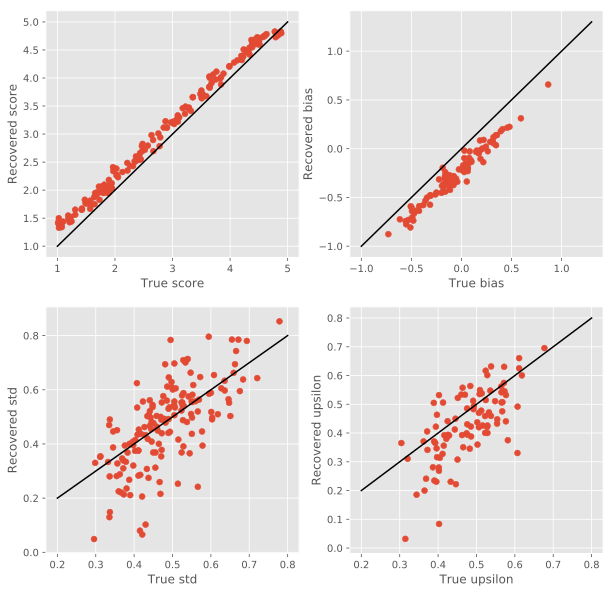

In [271]:
g = tf.Graph()
with g.as_default():
    s = make_sample()
with tf.Session(graph=g) as sess:
    delta,psi,upsilon,fi,o = sess.run(s)

g = tf.Graph()
with g.as_default():
    # random start conditions
    delta_s,psi_s,upsilon_s,fi_s,_ = make_sample()
    
    tf_delta = tf.Variable(delta_s)
    tf_psi_var = tf.Variable((psi_s-np.float64(1.0))/np.float64(4.0))
    tf_psi = np.float64(1.0) + np.float64(4.0) * tf.nn.sigmoid(tf_psi_var)

    
    tf_upsilon_sqr = tf.Variable(tf.sqrt(upsilon_s))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(tf.sqrt(fi_s))
    tf_fi = tf_fi_sqr**2
    
    log_prob = log_joint(tf_delta,tf_psi,tf_upsilon,tf_fi,o,prior=False)
    loss = -log_prob/(nSub*nPVS)
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.02, epsilon=0.01).minimize(loss)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _,np_loss = sess.run([train_op,loss])
        if i % 300 ==0:
            print(i,np_loss)

    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])

make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat)

### MAP

0 2.85147428470598
500 1.2684909839807081
1000 1.1029379552219527
1500 1.0288202193703222
2000 0.9909673946330687
2500 0.9708509518935569
3000 0.959735946475244
3500 0.9533222035134123
4000 0.9494458078327207
4500 0.9469886461648422
5000 0.9453559955256147
5500 0.9442215052949444
6000 0.9434000446729097
6500 0.9427829412522685
7000 0.9423041941514603
7500 0.9419223647965181
8000 0.9416105902965146
8500 0.9413509164838333
9000 0.9411309913078741
9500 0.9409420830563497


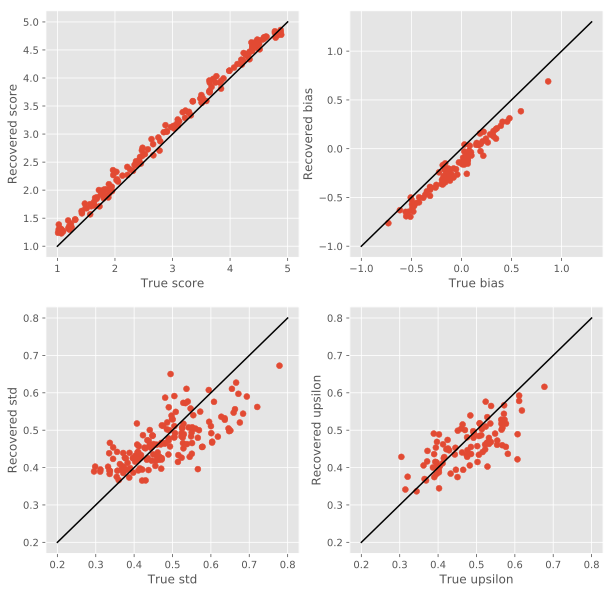

In [272]:

g = tf.Graph()
with g.as_default():
    # random start conditions
    delta_s,psi_s,upsilon_s,fi_s,_ = make_sample()
    
    tf_delta = tf.Variable(delta_s)
    tf_psi_var = tf.Variable((psi_s-np.float64(1.0))/np.float64(4.0))
    tf_psi = np.float64(1.0) + np.float64(4.0) * tf.nn.sigmoid(tf_psi_var)

    
    tf_upsilon_sqr = tf.Variable(tf.log(upsilon_s))
    tf_upsilon = tf.exp(tf_upsilon_sqr)
    
    tf_fi_sqr = tf.Variable(tf.log(fi_s))
    tf_fi = tf.exp(tf_fi_sqr)
    
    log_prob = log_joint(tf_delta,tf_psi,tf_upsilon,tf_fi,o)
    loss = -log_prob/(nSub*nPVS)
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.02, epsilon=0.01).minimize(loss)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _,np_loss = sess.run([train_op,loss])
        if i % 500 ==0:
            print(i,np_loss)

    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])

make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat)

## MCMC

In [273]:
def target_log_prob_fn(delta_o, psi_o, upsilon_o, fi_o):
    """Unnormalized target density as a function of states."""
    psi = np.float64(1.0) + np.float64(4.0) * tf.nn.sigmoid(psi_o)
    upsilon = tf.exp(upsilon_o)
    fi = tf.exp(fi_o)
    return log_joint(delta_o, psi, upsilon, fi,o)
    
g = tf.Graph()
with g.as_default():
    # random start conditions
    delta_s,psi_s,upsilon_s,fi_s,_ = make_sample()
    
    num_results = 10000
    num_burnin_steps = 3000
    
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            delta_s,
            (psi_s-np.float64(1.0))/np.float64(4.0),
            tf.log(upsilon_s),
            tf.log(fi_s)
        ],
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.01,
            num_leapfrog_steps=3))
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    np_states,acepted = sess.run([states,kernel_results.is_accepted])



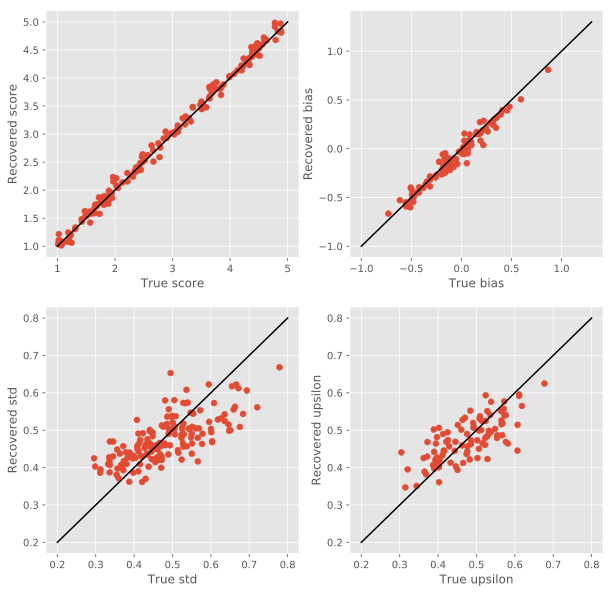

In [274]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

np_states[1] = 1 + 4*sigmoid(np_states[1])

np_states[2] = np.exp(np_states[2])
np_states[3] = np.exp(np_states[3])

(delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat)=map(lambda x: np.mean(x,axis=0),np_states)

make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat)

Text(0,0.5,'$\\hat \\psi$')

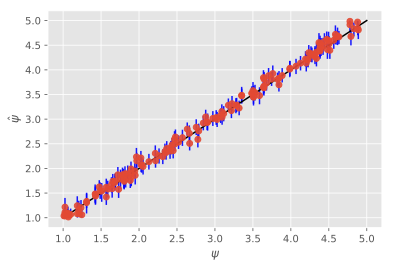

In [275]:
ax = plt.subplot()
err = [psi_hat-np.percentile(np_states[1],q=2.5,axis=0),
      np.percentile(np_states[1],q=97.5,axis=0)-psi_hat]

ax.errorbar(x=psi,y=psi_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([1,5],[1,5],'k')
ax.set_xlabel(r'$\psi$')
ax.set_ylabel(r'$\hat \psi$')


Text(0,0.5,'$\\hat \\delta$')

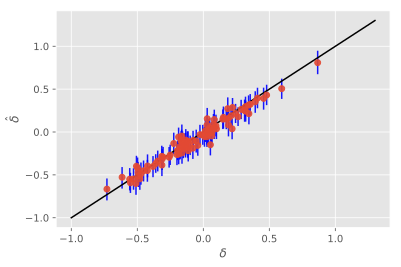

In [276]:
ax = plt.subplot()
err = [delta_hat-np.percentile(np_states[0],q=2.5,axis=0),
      np.percentile(np_states[0],q=97.5,axis=0)-delta_hat]

ax.errorbar(x=delta,y=delta_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([-1,1.3],[-1,1.3],'k')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\hat \delta$')


Text(0,0.5,'$\\hat \\upsilon$')

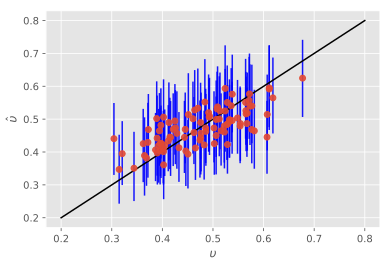

In [277]:
ax = plt.subplot()
err = [upsilon_hat-np.percentile(np_states[2],q=2.5,axis=0),
      np.percentile(np_states[2],q=97.5,axis=0)-upsilon_hat]

ax.errorbar(x=upsilon,y=upsilon_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([0.2,0.8],[0.2,0.8],'k')
ax.set_xlabel(r'$\upsilon$')
ax.set_ylabel(r'$\hat \upsilon$')


Text(0,0.5,'$\\hat \\phi$')

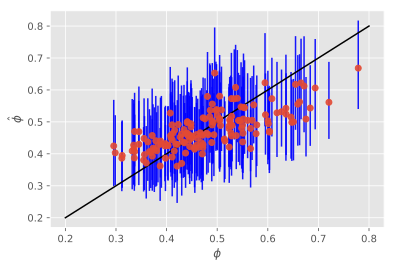

In [278]:
ax = plt.subplot()
err = [fi_hat-np.percentile(np_states[3],q=2.5,axis=0),
      np.percentile(np_states[3],q=97.5,axis=0)-fi_hat]

ax.errorbar(x=fi,y=fi_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([0.2,0.8],[0.2,0.8],'k')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\hat \phi$')
